In [1]:
%run ./../data/load-dataset.ipynb
%run ./../homegrown/basic-neural-network.ipynb
%run ../doc2vec/load-d2v-model.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
ITERS = 100

RANDOM_SEED = 0

In [4]:
corpus, labels = df[[proc_doc_col, label_col]].T.values
X = np.array([d2v_model.dv[i] for i in range(len(corpus))])
y = np.array([np.eye(2)[int(label)] for label in labels])
train_samples, test_samples, train_labels, test_labels = train_test_split(X, y, random_state=RANDOM_SEED)

In [5]:
hidden_layer_size = 100
iterations = ITERS + 1
alpha = 1e-3
batch_size = 64  # set to 1 for stochastic gradient descent
hid_activation = Activation.RELU
out_activation = Activation.SIGMOID
dropout = True
as_probs = True
skip_remaining = True
yield_results = True
silent = False
random_seed = RANDOM_SEED

model = BasicNeuralNetwork(hidden_layer_size, epochs=iterations, alpha=alpha,
                           batch_size=batch_size, skip_remaining=skip_remaining,
                           hid_activation=hid_activation, out_activation=out_activation, 
                           dropout=dropout, as_probs=as_probs, 
                           yield_results=yield_results, silent=silent, random_seed=random_seed)

data = []
predict_sentiment_gen = model.evaluate(train_samples, test_samples, train_labels, test_labels)
for (train_preds, train_errors), (test_preds, test_errors) in predict_sentiment_gen:
    train_loss = sum(train_errors) / len(train_samples)
    train_correct = sum([np.argmax(pred) == np.argmax(label)
                         for pred, label
                         in zip(train_preds, train_labels)])
    train_accuracy = train_correct / len(train_samples)
    
    test_loss = sum(test_errors) / len(test_samples)
    test_correct = sum([np.argmax(pred) == np.argmax(label)
                        for pred, label
                        in zip(test_preds, test_labels)])
    test_accuracy = test_correct / len(test_samples)
    
    data.append({'Train Predictions': train_preds, 'Train Errors': train_errors,
                 'Train Loss (MSE)': train_loss, 'Train Accuracy': train_accuracy,
                 'Test Predictions': test_preds, 'Test Errors': test_errors,
                 'Test Loss (MSE)': test_loss, 'Test Accuracy': test_accuracy,
                 'Correct (Train)': train_correct, 'Correct (Test)': test_correct})

results = pd.DataFrame(data)
results[['Train Loss (MSE)', 'Train Accuracy', 'Test Loss (MSE)', 'Test Accuracy']][::10].style \
            .highlight_min(subset=['Train Accuracy', 'Test Accuracy'], color='lightcoral') \
            .highlight_max(subset=['Train Accuracy', 'Test Accuracy'], color='lightgreen') \
            .highlight_min(subset=['Train Loss (MSE)', 'Test Loss (MSE)'], color='lightgreen') \
            .highlight_max(subset=['Train Loss (MSE)', 'Test Loss (MSE)'], color='lightcoral')

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:52<00:00,  1.11s/it]


,Train Loss (MSE),Train Accuracy,Test Loss (MSE),Test Accuracy
0,0.429749,0.655117,0.388390,0.702650
10,0.331304,0.753100,0.348347,0.738300
20,0.296152,0.781767,0.350305,0.733600
30,0.276126,0.799150,0.357833,0.731650
40,0.259179,0.811217,0.362495,0.731150
50,0.249129,0.817383,0.368639,0.726300
60,0.238615,0.824500,0.374627,0.727500
70,0.234356,0.826600,0.379983,0.725850
80,0.228932,0.830717,0.384428,0.723450
90,0.225472,0.832333,0.388167,0.722750


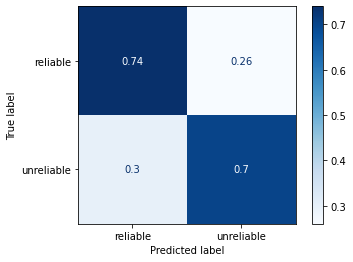

In [6]:
normalize = 'true'

true_preds, true_labels = [np.argmax(pred) for pred in test_preds], \
                          [np.argmax(label) for label in test_labels]
ConfusionMatrixDisplay.from_predictions(true_labels, true_preds, normalize=normalize,
                                        cmap=plt.cm.Blues, display_labels=('reliable', 'unreliable'))